# 7. Logistic Regression with PyTorch
## 1. About Logistic Regression


### 1.3 Logistic Regression In-Depth

#### Predicting Probability
- Linear regression doesn't work
- Instead of predicting direct values: **predict probability**

<img src="./images/cross_entropy_final_4.png" alt="deeplearningwizard" style="width: 900px;"/>

#### Logistic Function $g()$ 
- Two-class logistic regression
- $ y = A x + b$
- $ g(y) = A x + b $
- $g(y) = \frac {1} {1 + e^{-y}} = \frac {1} {1 + e^{-(A x + b)}}$
- $g(y)$ = Estimated probability that $y = 1$ given $x$


#### Softmax Function $g()$ 
- Multi-class logistic regression
- Generalization of logistic function


#### Cross Entropy Function $D()$
- $D(S, L) = L log S - (1-L)log(1-S)$
    - If L = 0 (label)
        - $D(S, 0) = - log(1-S)$
            - $- log(1-S)$: less positive if $S \longrightarrow 0 $
            - $- log(1-S)$: more positive if $S \longrightarrow 1 $ (BIGGER LOSS)
    - If L = 1 (label)
        - $D(S, 1) = log S$
            - $logS$: less negative if $S \longrightarrow 1 $
            - $logS$: more negative if $S \longrightarrow 0 $ (BIGGER LOSS)

In [1]:
import math
print(-math.log(1 - 0.00001))
print(-math.log(1 - 0.99999))

print(math.log(0.99999))
print(math.log(0.00001))

1.0000050000287824e-05
11.51292546497478
-1.0000050000287824e-05
-11.512925464970229


#### Cross Entropy Loss $L$
- Goal: Minimizing Cross Entropy Loss
- $ L = \frac {1}{N} \sum_i D(g(Ax_i + b), L_i)$

## 2. Building a Logistic Regression Model with PyTorch

<img src="./images/lr2.png" alt="deeplearningwizard" style="width: 900px;"/>

### Steps
- Step 1: Load Dataset
- Step 2: Make Dataset Iterable
- Step 3: Create Model Class
- Step 4: Instantiate Model Class
- Step 5: Instantiate Loss Class
- Step 6: Instantiate Optimizer Class
- Step 7: Train Model

### Step 1a: Loading MNIST Train Dataset
**Images from 1 to 9**

In [3]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets

In [4]:
train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

Processing...
Done!


In [25]:
print('Training data size: {}'.format(len(train_dataset)))
print('Dimentions of each items in one observation: {}'.format(train_dataset[0][0].shape))

Training data size: 60000
Dimentions of each items in one observation: torch.Size([1, 28, 28])


In [26]:
# Label
train_dataset[0][1]

tensor(5)

#### Displaying MNIST

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline  
import numpy as np

In [28]:
train_dataset[0][0].numpy().shape

(1, 28, 28)

In [29]:
show_img = train_dataset[0][0].numpy().reshape(28, 28)

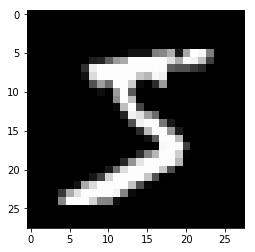

In [30]:
plt.imshow(show_img, cmap='gray')

In [15]:
# Label
train_dataset[0][1]

tensor(5)

### Step 1b: Loading MNIST Test Dataset
- Show our algorithm works beyond the data we have trained on.
- Out-of-sample

In [31]:
test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())

In [32]:
len(test_dataset)

10000

In [33]:
type(test_dataset[0])

tuple

In [34]:
# Image matrix
test_dataset[0][0].size()

torch.Size([1, 28, 28])

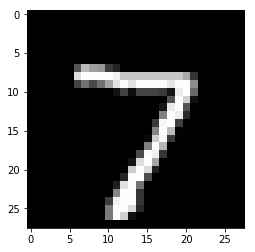

In [35]:
show_img = test_dataset[0][0].numpy().reshape(28, 28)
plt.imshow(show_img, cmap='gray')

In [36]:
# Label
test_dataset[0][1]

tensor(7)

### Step 2: Make Dataset Iterable
- Aim: make the dataset iterable
- **totaldata**: 60000
- **minibatch**: 100
    - Number of examples in 1 iteration
- **iterations**: 3000
    - 1 iteration: one mini-batch forward & backward pass
- **epochs**
    - 1 epoch: running through the whole dataset once
    - $epochs = iterations \div \frac{totaldata}{minibatch} = 3000 \div \frac{60000}{100} = 5 $
    

In [37]:
len(train_dataset)

60000

In [38]:
batch_size = 100

In [39]:
n_iters = 3000

In [40]:
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)
num_epochs

5

#### Create Iterable Object: Training Dataset

In [41]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

#### Check Iterability

In [42]:
import collections
isinstance(train_loader, collections.Iterable)

True

#### Create Iterable Object: Testing Dataset

In [43]:
# Iterable object
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

#### Check Iterability

In [44]:
isinstance(test_loader, collections.Iterable)

True

### Step 3: Building Model

In [45]:
# Same as linear regression! 
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
    
    def forward(self, x):
        out = self.linear(x)
        return out

### Step 4: Instantiate Model Class
- Input dimension: 
    - Size of image
    - $28 \times 28 = 784$
- Output dimension: 10
    - 0, 1, 2, 3, 4, 5, 6, 7, 8, 9

In [46]:
# Size of images
train_dataset[0][0].size()

torch.Size([1, 28, 28])

In [47]:
input_dim = 28*28
output_dim = 10

model = LogisticRegressionModel(input_dim, output_dim)

### Step 5: Instantiate Loss Class
- **Logistic Regression**: Cross Entropy Loss
    - _Linear Regression: MSE_
   

In [48]:
criterion = nn.CrossEntropyLoss()  

#### What happens in `nn.CrossEntropyLoss()`?
- Computes softmax (logistic/softmax function)
- Computes cross entropy

### Step 6: Instantiate Optimizer Class
- Simplified equation
    - $\theta = \theta - \eta \cdot \nabla_\theta $
        - $\theta$: parameters (our variables)
        - $\eta$: learning rate (how fast we want to learn)
        - $\nabla_\theta$: parameters' gradients
- Even simplier equation
    - `parameters = parameters - learning_rate * parameters_gradients`
    - **At every iteration, we update our model's parameters**

In [49]:
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

### Parameters In-Depth

In [56]:
for n,v in model.named_parameters():
    print(n,v.shape)
# FC 1 Parameters 
print(list(model.parameters())[0].size())
# FC 1 Bias Parameters
print(list(model.parameters())[1].size())

linear.weight torch.Size([10, 784])
linear.bias torch.Size([10])
torch.Size([10, 784])
torch.Size([10])


### Step 7: Train Model
- Process 
    1. Convert inputs/labels to variables
    2. Clear gradient buffets
    3. Get output given inputs 
    4. Get loss
    5. Get gradients w.r.t. parameters
    6. Update parameters using gradients
        - `parameters = parameters - learning_rate * parameters_gradients`
    7. REPEAT

In [57]:
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Load images as Variable
        images = images.view(-1, 28*28)
        labels = labels
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Forward pass to get output/logits
        outputs = model(images)
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        
        iter += 1
        
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                # Load images to a Torch Variable
                images = images.view(-1, 28*28).requires_grad_()
                
                # Forward pass only to get logits/output
                outputs = model(images)
                
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                
                # Total number of labels
                total += labels.size(0)
                
                # Total correct predictions
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / total
            
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 1.8770848512649536. Accuracy: 68
Iteration: 1000. Loss: 1.5890693664550781. Accuracy: 76
Iteration: 1500. Loss: 1.306788682937622. Accuracy: 79
Iteration: 2000. Loss: 1.293239712715149. Accuracy: 81
Iteration: 2500. Loss: 1.068131685256958. Accuracy: 82
Iteration: 3000. Loss: 0.9700384736061096. Accuracy: 82


#### Break Down Accuracy Calculation

In [69]:
iter_test = 0
for images, labels in test_loader:
    iter_test += 1
    if iter_test == 1:
        images = images.view(-1, 28*28).requires_grad_()
        outputs = model(images)
        print('OUTPUTS')
        print(outputs.size())
        _, predicted = torch.max(outputs.data, 1)
        print(_.shape,predicted.shape)
        
        print(outputs[0,:])
        print('Predicted label: ',_[0],predicted[0])
        print('Actual label: ',labels[0])

OUTPUTS
torch.Size([100, 10])
torch.Size([100]) torch.Size([100])
tensor([-0.3570, -1.2050, -0.4114, -0.0978,  0.1247, -0.3598, -1.0687,  2.9219,
        -0.2520,  0.7307], grad_fn=<SelectBackward>)
Predicted label:  tensor(2.9219) tensor(7)
Actual label:  tensor(7)


In [70]:
correct = 0
total = 0
iter_test = 0
for images, labels in test_loader:
    iter_test += 1
    images = images.view(-1, 28*28).requires_grad_()
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    
    # Total number of labels
    total += labels.size(0)

    # Total correct predictions
    correct += (predicted == labels).sum()

accuracy = 100 * (correct.item() / total) ## tensor.item() convert tensor to actual value

print(accuracy)

82.85


#### Saving Model

In [76]:
save_model = False
if save_model is True:
    # Saves only parameters
    torch.save(model.state_dict(), 'awesome_model.pkl')

## 3. Building a Logistic Regression Model with PyTorch (GPU)



GPU: 2 things must be on GPU
- `model`
- `variables`

In [77]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets

'''
STEP 1: LOADING DATASET
'''

train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())

'''
STEP 2: MAKING DATASET ITERABLE
'''

batch_size = 100
n_iters = 3000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

'''
STEP 3: CREATE MODEL CLASS
'''
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
    
    def forward(self, x):
        out = self.linear(x)
        return out

'''
STEP 4: INSTANTIATE MODEL CLASS
'''
input_dim = 28*28
output_dim = 10

model = LogisticRegressionModel(input_dim, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

'''
STEP 5: INSTANTIATE LOSS CLASS
'''
criterion = nn.CrossEntropyLoss()


'''
STEP 6: INSTANTIATE OPTIMIZER CLASS
'''
learning_rate = 0.001

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

'''
STEP 7: TRAIN THE MODEL
'''
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Forward pass to get output/logits
        outputs = model(images)
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        
        iter += 1
        
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                images = images.view(-1, 28*28).to(device)
                
                # Forward pass only to get logits/output
                outputs = model(images)
                
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                
                # Total number of labels
                total += labels.size(0)
                
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()
            
            accuracy = 100 * correct.item() / total
            
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 1.8586865663528442. Accuracy: 67.95
Iteration: 1000. Loss: 1.5713390111923218. Accuracy: 77.44
Iteration: 1500. Loss: 1.2804371118545532. Accuracy: 80.19
Iteration: 2000. Loss: 1.1797147989273071. Accuracy: 81.61
Iteration: 2500. Loss: 1.1515697240829468. Accuracy: 82.62
Iteration: 3000. Loss: 0.9987438321113586. Accuracy: 83.27
